In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
(train_data, test_data), ds_info = tfds.load(name="beans",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteGV892G/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteGV892G/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteGV892G/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
len(train_data), len(test_data)

(1034, 133)

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(500, 500, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
})

In [5]:
class_names = ds_info.features['label'].names

In [6]:
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

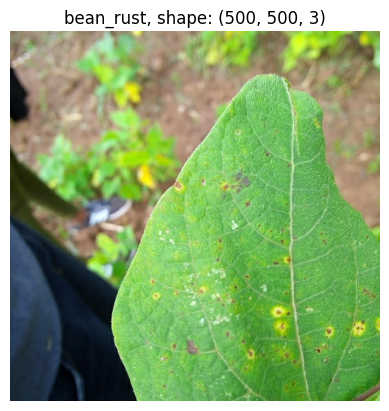

In [7]:
for img, target in train_data.take(1):
  plt.title(f'{class_names[target.numpy()]}, shape: {img.shape}')
  plt.imshow(img)
  plt.axis('off')

In [8]:
def preprocess_image(image, label, target_image_shape=224, normalization_factor=None):
  """
  Takes an image and its label and changes its shape. If normalization_factor is not None, normalizes it.
  """
  image = tf.image.resize(image, [target_image_shape, target_image_shape])

  if normalization_factor:
    image /= normalization_factor
  return image, label

In [9]:
train_dataset = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16).prefetch(tf.data.AUTOTUNE)

In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
base = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base.trainable = False

input = tf.keras.Input(shape=(224, 224, 3))
x = base(input, training=False)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(3)(x)

model = tf.keras.Model(input, output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                 weight_decay=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [12]:
history = model.fit(train_dataset, steps_per_epoch=len(train_dataset),
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset),
                    epochs=6)

Epoch 1/6
65/65 [==============================] - 62s 838ms/step - loss: 2.6594 - accuracy: 0.5309 - val_loss: 0.8849 - val_accuracy: 0.7293
Epoch 2/6
65/65 [==============================] - 52s 805ms/step - loss: 1.4405 - accuracy: 0.6712 - val_loss: 0.6512 - val_accuracy: 0.7970
Epoch 3/6
65/65 [==============================] - 54s 825ms/step - loss: 1.0729 - accuracy: 0.7466 - val_loss: 0.6154 - val_accuracy: 0.8271
Epoch 4/6
65/65 [==============================] - 55s 846ms/step - loss: 0.9004 - accuracy: 0.7950 - val_loss: 0.4937 - val_accuracy: 0.8496
Epoch 5/6
65/65 [==============================] - 53s 822ms/step - loss: 0.7055 - accuracy: 0.8153 - val_loss: 0.4615 - val_accuracy: 0.8571
Epoch 6/6
65/65 [==============================] - 53s 825ms/step - loss: 0.6398 - accuracy: 0.8288 - val_loss: 0.3672 - val_accuracy: 0.8947


In [13]:
for layer in model.layers:
    layer.trainable = True

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,
                                                 weight_decay=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_fine_tuned = model.fit(train_dataset, steps_per_epoch=len(train_dataset),
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset),
                    epochs=10,
                    initial_epoch=history.epoch[-1])

Epoch 6/10
65/65 [==============================] - 186s 3s/step - loss: 0.4484 - accuracy: 0.8598 - val_loss: 0.3782 - val_accuracy: 0.9023
Epoch 7/10
65/65 [==============================] - 160s 2s/step - loss: 0.4027 - accuracy: 0.8723 - val_loss: 0.3008 - val_accuracy: 0.9173
Epoch 8/10
65/65 [==============================] - 162s 2s/step - loss: 0.2195 - accuracy: 0.9130 - val_loss: 0.2425 - val_accuracy: 0.9173
Epoch 9/10
65/65 [==============================] - 171s 3s/step - loss: 0.1960 - accuracy: 0.9255 - val_loss: 0.2904 - val_accuracy: 0.9173
Epoch 10/10
65/65 [==============================] - 163s 3s/step - loss: 0.1494 - accuracy: 0.9381 - val_loss: 0.2455 - val_accuracy: 0.9248


In [15]:
model.save_weights('./checkpoints/my_checkpoint')